In [8]:
import pandas as pd
import numpy as np
from sklearn.impute import KNNImputer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import xgboost as xgb
import joblib
import warnings
warnings.filterwarnings("ignore")

# Load data
clean_data = pd.read_csv(r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\mixed_filtered.csv", delimiter=",")

# Train-test split: cellulose samples as test set
train_data = clean_data[clean_data['fuel_type'] != 'digestate_pe']
test_data = clean_data[clean_data['fuel_type'] == 'digestate_pe']

# Extract features and target
X_train = train_data.drop(columns=['Unnamed: 0','sample', 'fuel_type', 'devol_yield', 'fuel_category'])
y_train = train_data['devol_yield']
X_test = test_data.drop(columns=['Unnamed: 0','sample', 'fuel_type', 'devol_yield', 'fuel_category'])
y_test = test_data['devol_yield']

# Feature scaling (not strictly needed for XGBoost, but keeping it consistent with MLP)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Define base XGBoost regressor
xgb_reg = xgb.XGBRegressor(objective='reg:squarederror', random_state=42)

# Hyperparameter space
param_dist = {
    'n_estimators': [100, 300, 500],
    'max_depth': [3, 5, 7],
    'learning_rate': [0.01, 0.1, 0.2],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'reg_alpha': [0, 0.1, 1],
    'reg_lambda': [1, 1.5, 2]
}

# Randomized Search with 5-fold cross-validation
random_search = RandomizedSearchCV(
    estimator=xgb_reg,
    param_distributions=param_dist,
    n_iter=20,
    cv=5,
    verbose=2,
    n_jobs=-1,
    random_state=42,
    scoring='r2'
)

# Fit model
random_search.fit(X_train_scaled, y_train)

# Best model
best_xgb = random_search.best_estimator_
print("\nBest Parameters Found:", random_search.best_params_)

# Evaluate on torrwash test set
y_pred = best_xgb.predict(X_test_scaled)
r2 = r2_score(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
mae = mean_absolute_error(y_test, y_pred)

print(f"\nEvaluation on Torr Washed Test Set:")
print(f"R² Score: {r2:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")

# Generalization check
cv_best_r2 = random_search.best_score_
test_r2 = r2_score(y_test, y_pred)

print(f"\nGeneralization Check:")
print(f"Cross-Validated R² (Train CV): {cv_best_r2:.4f}")
print(f"Test R² (on unseen test set): {test_r2:.4f}")

gap = cv_best_r2 - test_r2
if gap > 0.1:
    print(f"⚠️ Warning: R² dropped by {gap:.4f} from CV to test — possible overfitting.")
elif gap < -0.05:
    print(f"ℹ️ Test R² is actually higher than CV R² — your model generalizes well!")
else:
    print("✅ No significant generalization gap detected.")

# Save model and scaler
joblib.dump(best_xgb, r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\best_xgb_model_plastic_test.pkl")
joblib.dump(scaler, r"C:\Users\demir\OneDrive\Desktop\MSc Thesis\Data\!mlp_lgbm_10.04\models\scaler_plastic.pkl")

print("\nModel and preprocessing pipeline saved.")


Fitting 5 folds for each of 20 candidates, totalling 100 fits

Best Parameters Found: {'subsample': 0.6, 'reg_lambda': 1, 'reg_alpha': 0, 'n_estimators': 100, 'max_depth': 3, 'learning_rate': 0.2, 'colsample_bytree': 0.8}

Evaluation on Torr Washed Test Set:
R² Score: 0.7670
RMSE: 10.6395
MAE: 7.8589

Generalization Check:
Cross-Validated R² (Train CV): 0.4613
Test R² (on unseen test set): 0.7670
ℹ️ Test R² is actually higher than CV R² — your model generalizes well!

Model and preprocessing pipeline saved.


Text(0, 0.5, 'Predicted devol_yield')

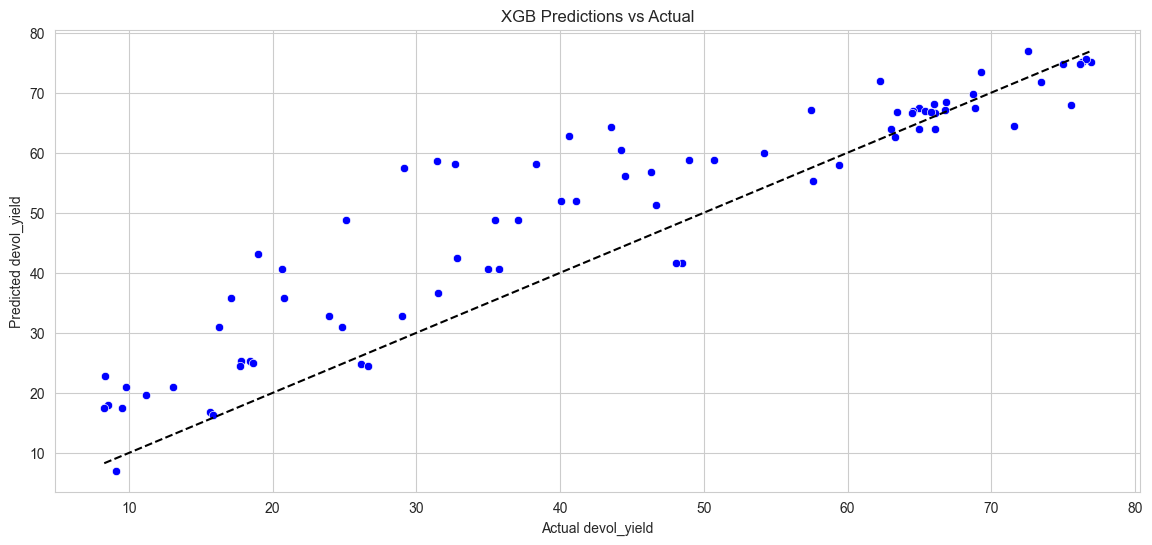

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 6))
sns.scatterplot(x=y_test, y=y_pred, color="blue")
plt.plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'k--')
plt.title("XGB Predictions vs Actual")
plt.xlabel("Actual devol_yield")
plt.ylabel("Predicted devol_yield")


(array([ 4., 14., 14., 12., 13.,  7.,  4.,  4.,  3.,  3.]),
 array([-7.51898395, -3.94239019, -0.36579642,  3.21079734,  6.78739111,
        10.36398487, 13.94057864, 17.5171724 , 21.09376617, 24.67035993,
        28.2469537 ]),
 <BarContainer object of 10 artists>)

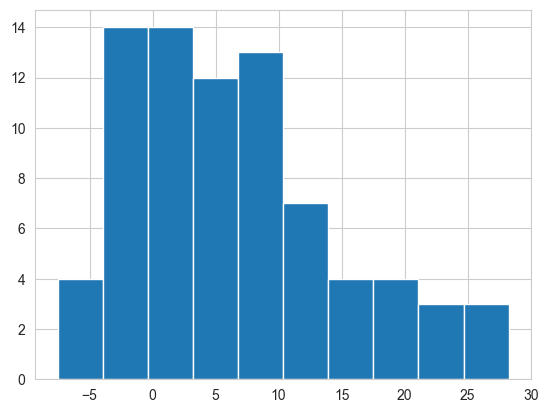

In [10]:
plt.hist(y_pred-y_test)